In [18]:
import os
import scipy.io as sio
import scipy.misc as smisc
import numpy as np
import re as regexp
import math
import matplotlib.pyplot as plt
import scipy

import scipy.io
import time
import glob,os
import cv2
from scipy import optimize
from pylab import *
from scipy import ndimage as ndi
import matplotlib.pyplot as plt
from skimage.feature import peak_local_max
from skimage import data, img_as_float
from scipy.ndimage import gaussian_filter

import imutils
import cv2
import csv
import struct
import bz2

In [74]:
dist_sqr = (coordinates[:,1] - x)**2 + (coordinates[:,0] - y)**2
print(dist_sqr)
print(argmin(dist_sqr[dist_sqr!=0]))
# remove duplicate if distance is smaller than 4
if np.amin(dist_sqr[dist_sqr!=0]) < 16:
    index = np.argmin(dist_sqr[dist_sqr!=0])
    peaks_x_fit = np.delete(peaks_x_fit,index)
    peaks_y_fit = np.delete(peaks_y_fit,index)

[18833 19337 18640 20090 18265 22637 20642 21130 18085 17002 16388 16066
 16573 18265 16666 15241 13973 14708 13577 15572 16474 16865 13028 13842
 12170 11668 15938 12745 13520 13109 11925 11428 10226 10169 10049 10477
 11540 12773 14501  8885 10170  9040 12377  7937  8245  9953  8900 12058
 10273  7085  6597  6770  9293  6920  7325  5813  5409  5050  9941  5917
  7465  8593  6793  4685  5380  3994  7321  4129  5200  5965  5098  3712
  6980  5729  2825  2929  3728  7204  4905  3985  4905  2434  2120  3049
  5449  2578  3613  5245  3208  1994  1405  1369  5989  3690  2125  2056
  5490   677   850  1066  1305  4010  2005  4162  2290  1037   530   373
  5440   265  1097  1300   468  2930  2522    68  1088  1636   545  3373
  3848  2120  1601     0]
115


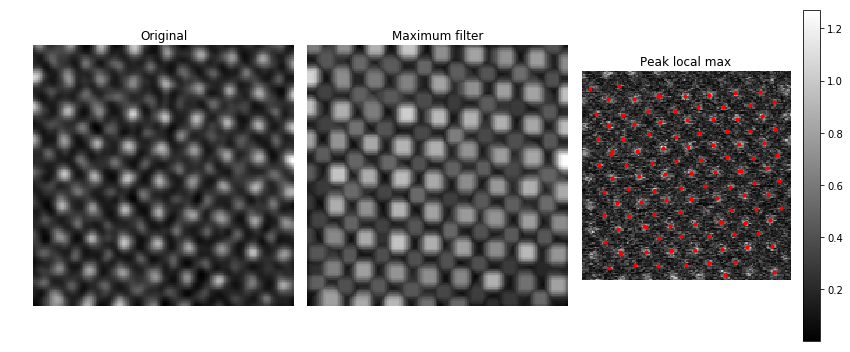

In [120]:
path = '/srv/home/chenyu/JDDC/Experiment/0.1us/data/rigidAverageStart.q2bz'
temp = LoadQ2bz(path)
im = gaussian_filter(temp,sigma=2)
image_max = ndi.maximum_filter(im, size=5, mode='constant')
coordinates = peak_local_max(temp, min_distance=5)
peaks_x_fit = []
peaks_y_fit = []
file1 = open("/srv/home/chenyu/JDDC/Experiment/0.1us/data/atoms.txt","w")

for i in range(coordinates.shape[0]):

    x = int(coordinates[i][1])
    y = int(coordinates[i][0])
    
    if x > 7 and y > 7:
        patch = im[y-7:y+7,x-7:x+7]
        bg = np.amin(patch)
        guess = (bg,patch[7,7]-bg,7, 7, 3, 3)
        bounds = ([min(0,bg),0,0,0,1,1],[np.inf,np.inf,14,14,10,10])
        param = fitGaussianx2(patch, guess, bounds)

        peaks_x_fit.append(param[2]+x-7)
        peaks_y_fit.append(param[3]+y-7)
        file1.write('%f %f\n' % (param[2]+x-7,param[3]+y-7))
file1.close()

# Check for duplicate ones
# i = 0
# while i < len(peaks_x_fit):
# #     print(i)
#     x = peaks_x_fit[i]
#     y = peaks_y_fit[i]
#     dist_sqr = (peaks_x_fit - x)**2 + (peaks_y_fit - y)**2
#     # remove duplicate if distance is smaller than 4
#     if np.amin(dist_sqr[dist_sqr!=0]) < 16:
#         print(x,y)
#         index = np.argmin(dist_sqr[dist_sqr!=0])
#         peaks_x_fit = np.delete(peaks_x_fit,index)
#         peaks_y_fit = np.delete(peaks_y_fit,index)
#     i = i + 1

# Display results
fig, axes = plt.subplots(1, 3, figsize=(12, 5), sharex=True, sharey=True)
ax = axes.ravel()
ax[0].imshow(im, cmap=plt.cm.gray)
ax[0].axis('off')
ax[0].set_title('Original')

ax[1].imshow(image_max, cmap=plt.cm.gray)
ax[1].axis('off')
ax[1].set_title('Maximum filter')

im2 = ax[2].imshow(np.transpose(temp), cmap=plt.cm.gray)
ax[2].autoscale(False)
ax[2].plot(peaks_y_fit,peaks_x_fit, 'r.')
ax[2].axis('off')
ax[2].set_title('Peak local max')
fig.colorbar(im2,ax=ax[2])

fig.tight_layout()

plt.show()

In [81]:
def LoadQ2(path):
# path = '/srv/home/chenyu/NRR/STO_NRR/QuantTest/0.5us/STO_Truth.q2'
# read header in read text mode
    fid = open(path, mode='rt',encoding = "ISO-8859-1")
    next(fid)    # magic number P9, skip
#     print(fid.readline())   # description line
    fid.readline()    # skip description line without print it 
    # print(fid.readline())    # do not print, but read the description line
    size = fid.readline()   # image size in width, height
    width = int(size.split(' ')[0])
    height = int(size.split(' ')[1][:-1])
    #     print(width, height)
    #     print(fid.readline())   # max?
    # each number is a 8 byte double format

    # read data part in read binary mode
    img = np.zeros((height,width))
    fid = open(path, mode='rb')
    for _ in range(4):
        next(fid)
    for icol in range(width):
        for irow in range(height):
            read_bytes = fid.read(8)
            img[irow,icol] = struct.unpack('d',read_bytes)[0]
    
    return img

#     plt.imshow(img)
#     plt.colorbar()

In [11]:
def LoadQ2bz(path):
#     path = '/srv/home/chenyu/NRR/STO_NRR/ParameterTest/Lambda/100/HAADF_NRR/stage3/average.q2bz'
    # read header in read text mode
    fid = bz2.open(path, mode='rt',encoding = "ISO-8859-1")
    next(fid)    # magic number P9, skip
#     print(fid.readline())   # description line
    fid.readline()    # do not print, but read the description line
    size = fid.readline()   # image size in width, height
    width = int(size.split(' ')[0])
    height = int(size.split(' ')[1][:-1])
#     print(width, height)
#     print(fid.readline())   # max?
    # each number is a 8 byte double format

    # read data part in read binary mode
    img = np.zeros((height,width))
    fid = bz2.open(path, mode='rb')
    for _ in range(4):
        next(fid)
    for icol in range(width):
        for irow in range(height):
            read_bytes = fid.read(8)
            img[irow,icol] = struct.unpack('d',read_bytes)[0]

#     plt.imshow(img)
#     plt.colorbar()
    return img

In [27]:
def LocatePeaks(path, coordinates, im):
    # Fit positions of each peak

    peaks_x_fit = []
    peaks_y_fit = []
    for i in range(coordinates.shape[0]):

        x = int(coordinates[i][1])
        y = int(coordinates[i][0])

        patch = im[y-7:y+7,x-7:x+7]
        bg = np.amin(patch)
        guess = (bg,patch[7,7]-bg,7, 7, 3, 3)
        bounds = ([min(0,bg),0,0,0,1,1],[np.inf,np.inf,14,14,10,10])
#         print(bounds)
#         print(guess)
        param = fitGaussianx2(patch, guess, bounds)

        peaks_x_fit.append(param[2]+x-7)
        peaks_y_fit.append(param[3]+y-7)

    fig = plt.figure(figsize=(5,5))
    im0 = plt.imshow(im,cmap=plt.cm.gray)
    fig.colorbar(im0)
    plt.scatter(peaks_x_fit,peaks_y_fit)
    plt.xticks([])
    plt.yticks([])

    peaks_x_fit = np.asarray(peaks_x_fit)
    peaks_y_fit = np.asarray(peaks_y_fit)
    np.save(path +'SrPeaks_x.npy',np.asarray(peaks_x_fit))
    np.save(path +'SrPeaks_y.npy',np.asarray(peaks_y_fit))

In [28]:
def gaussianx2(xdata_tuple,bg,height, center_x, center_y, width_x, width_y):

    (x, y) = xdata_tuple
    width_x = float(width_x)
    width_y = float(width_y)
    g = height*exp(
                 -(((center_x-x)/width_x)**2+((center_y-y)/width_y)**2)/2)+bg
    return g.ravel()

In [29]:
def fitGaussianx2(data, guess, bounds):
    x = np.linspace(0, data.shape[1]-1, data.shape[1])
    y = np.linspace(0, data.shape[0]-1, data.shape[0])
    x, y = np.meshgrid(x, y)
    xdata_tuple = (x,y)
    popt, pcov = optimize.curve_fit(gaussianx2, xdata_tuple, data.ravel(), p0=guess,bounds=bounds,method='trf',verbose=0,maxfev=100000)
    return popt